<a href="https://colab.research.google.com/github/NayanaPradeep/Airline-Passenger-Referral-Prediction/blob/main/Airline_Passenger_Referral_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROBLEM**

Data includes airline reviews from 2006 to 2019 for popular airlines around the world with
multiple choice and free text questions. Data is scraped in Spring 2019. The main objective
is to predict whether passengers will refer the airline to their friends.

Feature descriptions briefly as follows:

*   airline: Name of the airline
*   overall: Overall point is given to the trip between 1 to 10.
*   author: Author of the trip
*   reviewdate: Date of the Review 
*   customer review: Review of the customers in  free text format
*   aircraft: Type of the aircraft
*   travellertype: Type of traveler (e.g. business, leisure)
*   cabin: Cabin at the flight 
*   date flown: Flight date
*   seatcomfort: Rated between 1-5
*   cabin service: Rated between 1-5
*   foodbev: Rated between 1-5 
*   entertainment: Rated between 1-5
*   groundservice: Rated between 1-5
*   valueformoney: Rated between 1-5
*   recommended: Binary, target variable


# **SOLUTION**

## **Importing the libraries**

In [1]:
#Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import lightgbm

import warnings
warnings.filterwarnings('ignore')

## **Reading the Dataset**

In [2]:
#Mount the drive to load the dataset 
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read the file
file_path = '/content/drive/MyDrive/Colab Notebooks/Airline Passenger Referral Prediction - Nayana Pradeep/data_airline_reviews.xlsx'
airline_df=pd.read_excel(file_path)

##  **Basic Data Analysis**

In [4]:
#Top 10 rows of the dataset
airline_df.head(10)

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Turkish Airlines,1.0,Pooja Jain,6th May 2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no


In [5]:
#Last 5 rows of the dataset
airline_df.tail()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
131890,Ukraine International,NaN,Andriy Yesypenko,19th May 2006,Kiev - London (Gatwick) in business class (in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131892,Ukraine International,NaN,Volodya Bilotkach,29th April 2006,Several flights - KBP to AMS (3 times one way)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131894,Ukraine International,NaN,Kasper Hettinga,10th February 2006,KBP-AMS with UIA. Although it was a relatively...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no


In [6]:
#Column names of the dataset
airline_df.columns

Index(['airline', 'overall', 'author', 'review_date', 'customer_review',
       'aircraft', 'traveller_type', 'cabin', 'route', 'date_flown',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended'],
      dtype='object')

In [7]:
#Number of rows and column
airline_df.shape

(131895, 17)

In [8]:
#Checking the unique values of the  recommended column(target variable)
airline_df.recommended.unique()

array([nan, 'yes', 'no'], dtype=object)

In [9]:
#Checking the types of travellers who submitted the review
airline_df.traveller_type.unique()

array([nan, 'Business', 'Family Leisure', 'Solo Leisure',
       'Couple Leisure'], dtype=object)

## **Null Values and Duplicates**

From the last 5 rows, we can conclude that the dataset contains null values. Let's check the number of null values present for each of the columns of this huge dataset. 

In [10]:
#Checking the null value count for each column
airline_df.isnull().sum()

airline             65948
overall             67878
author              65948
review_date         65948
customer_review     65948
aircraft           112177
traveller_type      92140
cabin               68592
route               92169
date_flown          92262
seat_comfort        71214
cabin_service       71180
food_bev            79287
entertainment       87702
ground_service      92537
value_for_money     67920
recommended         67455
dtype: int64

In [11]:
def missing_values_per_check(df):
    percent_missing = airline_df.isnull().sum() * 100 / len(airline_df)
    missing_values_df = pd.DataFrame({'column_name': airline_df.columns,
                                     'percent_missing': percent_missing})
    return missing_values_df.sort_values('percent_missing',ascending=False)

In [12]:
missing_values_per_check(airline_df)

,column_name,percent_missing
aircraft,aircraft,85.050229
ground_service,ground_service,70.159597
date_flown,date_flown,69.951097
route,route,69.880587
traveller_type,traveller_type,69.858600
entertainment,entertainment,66.493802
food_bev,food_bev,60.113727
seat_comfort,seat_comfort,53.992949
cabin_service,cabin_service,53.967171
cabin,cabin,52.005004


From the above analysis, it is clear that our dataset contains lot of null values. Since 'recommended' is the target variable here, lets concentrate the null value count of 'recommended' first.

Let's check the subset of the dataset which has null values for 'recommended'

In [13]:
#Creating a copy before the data preparation and analysis
airline_df_copy =airline_df.copy()

In [14]:
#new dataset with rows where recommended is null
recommended_null = airline_df[airline_df['recommended'].isnull()]

In [15]:
#checking the null count for this particular subset
recommended_null.isnull().sum()

airline            65948
overall            65968
author             65948
review_date        65948
customer_review    65948
aircraft           67454
traveller_type     67454
cabin              67454
route              67454
date_flown         67455
seat_comfort       67455
cabin_service      67455
food_bev           67455
entertainment      67455
ground_service     67455
value_for_money    67455
recommended        67455
dtype: int64

In [16]:
#Function to check the null value percentage
missing_values_per_check(recommended_null)

,column_name,percent_missing
aircraft,aircraft,85.050229
ground_service,ground_service,70.159597
date_flown,date_flown,69.951097
route,route,69.880587
traveller_type,traveller_type,69.858600
entertainment,entertainment,66.493802
food_bev,food_bev,60.113727
seat_comfort,seat_comfort,53.992949
cabin_service,cabin_service,53.967171
cabin,cabin,52.005004


Now it's clear that the subset with null values for 'recommended' column comes with approximately same amount of null values for the other columns.

This subset of dataset can corrupt the analysis and prediction because it is almost full of null values. So it is safer to remove these columns from the original dataset

In [17]:
#Number of rows and columns in this subset dataset
recommended_null.shape

(67455, 17)

In [18]:
#remove the rows where recommended value is null
airline_df.drop(airline_df[airline_df['recommended'].isnull()].index, inplace = True)

In [19]:
#Number of rows and columns of the improved and new dataset
airline_df.shape

(64440, 17)

In [20]:
#Function to check the null value percentage
missing_values_per_check(airline_df)

,column_name,percent_missing
aircraft,aircraft,69.402545
ground_service,ground_service,38.923029
date_flown,date_flown,38.496276
route,route,38.353507
traveller_type,traveller_type,38.308504
entertainment,entertainment,31.419926
food_bev,food_bev,18.361266
seat_comfort,seat_comfort,5.833333
cabin_service,cabin_service,5.780571
overall,overall,2.963998


In [21]:
#Showing the unique aircraft names
airline_df.aircraft.unique()

array([nan, 'A330', 'Boeing 737-800 / A330-300', ...,
       'Boeing 737-800 and Embraer 190', 'Boeing 737-400/ 737-800',
       'boeing 767'], dtype=object)

In [22]:
#checking the number of unique aircrafts
airline_df.aircraft.nunique()

2088

1.   The number of aircraft is very large.So is the percentage of null values in them.
So this column can be removed.
2.   Percentage of null values in date_flown is also big. As we will be focusing more on the reviews and it's subset scores, we can drop this column to reduce the null values.
3.   The column 'author' doesnt have any significance for the prediction. So this column can also be dropped.

In [23]:
#Dropping the least significant null value columns
airline_df.drop(["aircraft","author","date_flown"], axis = 1, inplace = True)

In [24]:
#Checking the new null value percentage
missing_values_per_check(airline_df)

,column_name,percent_missing
ground_service,ground_service,38.923029
route,route,38.353507
traveller_type,traveller_type,38.308504
entertainment,entertainment,31.419926
food_bev,food_bev,18.361266
seat_comfort,seat_comfort,5.833333
cabin_service,cabin_service,5.780571
overall,overall,2.963998
cabin,cabin,1.765984
value_for_money,value_for_money,0.721601


We are still left with lot of null values. Lets drop the rows with remaining null values in them.

In [25]:
#Dropping the null value rows
airline_df.dropna(axis=0,how='any',inplace = True)

In [26]:
#Checking the number of duplicates in the dataset
len(airline_df[airline_df.duplicated( keep='first')])

1744

In [27]:
#Removing the duplicates
airline_df.drop_duplicates(keep='first', inplace = True)

In [28]:
#confirming that the duplicate rows are deleted
len(airline_df[airline_df.duplicated( keep='first')])

0

In [29]:
#Checking the new null value percentage
missing_values_per_check(airline_df)

,column_name,percent_missing
airline,airline,0.0
overall,overall,0.0
review_date,review_date,0.0
customer_review,customer_review,0.0
traveller_type,traveller_type,0.0
cabin,cabin,0.0
route,route,0.0
seat_comfort,seat_comfort,0.0
cabin_service,cabin_service,0.0
food_bev,food_bev,0.0


In [30]:
#Comparing the size of changed dataset with original dataset and calculating its percentage
perc =(len(airline_df)/len(airline_df_copy))  * 100
perc

17.306190530346107

After removing the messy and duplicate data, the dataset is down to around 17% of the original data!! But it is all clean.

It is better to work with clean data for prediction rather than huge corrupt data.

## **Exploratory Data Analysis And Visualization**

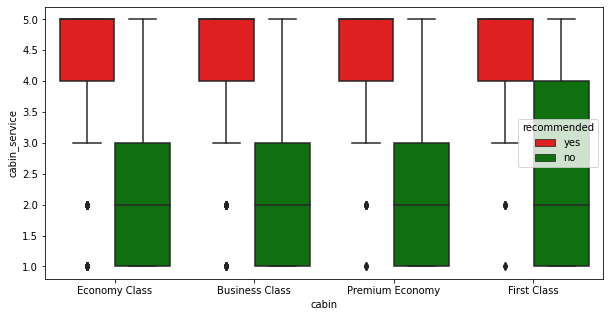

In [31]:
#Cabin type and cabin service ratings
plt.figure(figsize=(10,5))
sns.boxplot(airline_df.cabin, airline_df.cabin_service, hue = airline_df['recommended'], palette= ['red','green'])



1.   First class travellers are least likely to recommend the airlines.

2.   Recommendation is most probable when the cabin service is given full star rating ie 5 out of 5 here.


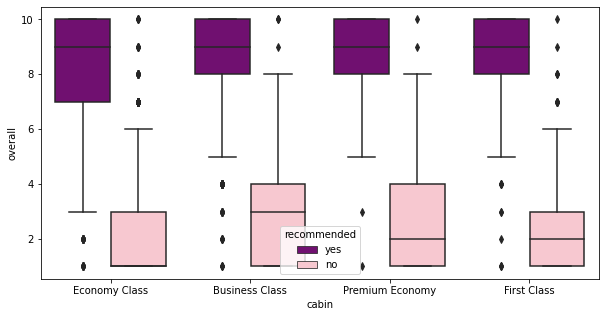

In [32]:
#Cabin type and overall service ratings (out of 10)
plt.figure(figsize=(10,5))
sns.boxplot(airline_df.cabin, airline_df.overall, hue = airline_df['recommended'], palette= ['purple','pink'])



*   If the trip is rated above 8 for overall section, the trip is most likely be recommended by the travellers.
*   If it is below 3 , the unhappy travellers has not referred the airlines to their friends irrespective of their cabin type.



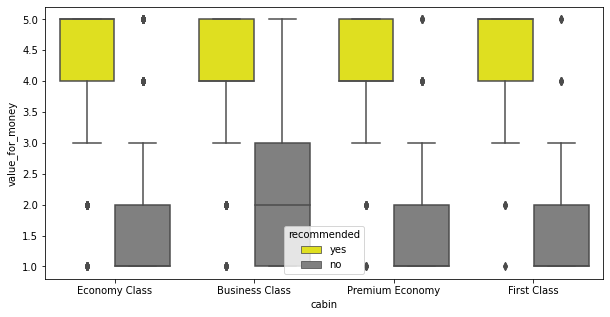

In [33]:
#Cabin type and value for money ratings (out of 5 )
plt.figure(figsize=(10,5))
sns.boxplot(airline_df.cabin, airline_df.value_for_money, hue = airline_df['recommended'], palette= ['yellow','grey'])

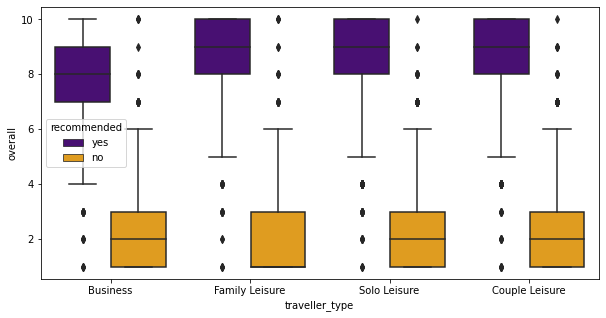

In [34]:
#Traveller type and overall service ratings (out of 10 )
plt.figure(figsize=(10,5))
sns.boxplot(airline_df.traveller_type, airline_df.overall, hue = airline_df['recommended'], palette= ['indigo','orange'])

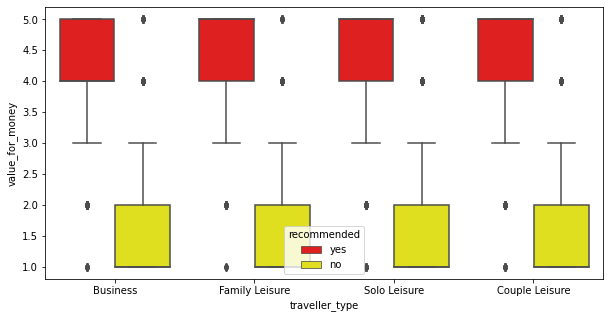

In [35]:
#Traveller type and value for money ratings (out of 5 )
plt.figure(figsize=(10,5))
sns.boxplot(airline_df.traveller_type, airline_df.value_for_money, hue = airline_df['recommended'], palette= ['red','yellow'])

When the cabin_Service is rated 5, it is highly likely that the reviewer has recommended the airlines to travel irrespective of the type of cabin.

Economy class is the most recommended cabin type, whereas business class is the least recommended one


In [36]:
#Check the unique overall ratings
airline_df.overall.unique()

array([ 7.,  2.,  3., 10.,  1.,  6.,  8.,  5.,  4.,  9.])

Since overall ratings are out of 10 and they don't have fractional values, the rest of the ratings are also scaled to 0-10 range for the convenience of comparison and visualization.

In [37]:
#Equalizing all kind of review score with overall score(which is out of 10)
airline_df["seat_comfort"] = airline_df["seat_comfort"]*2
airline_df["cabin_service"] = airline_df["cabin_service"]*2
airline_df["food_bev"] = airline_df["food_bev"]*2
airline_df["entertainment"] = airline_df["entertainment"]*2
airline_df["ground_service"] = airline_df["ground_service"]*2
airline_df["value_for_money"] = airline_df["value_for_money"]*2

In [38]:
#Grouping the various ratings columns to one list
review_columns = ['overall','seat_comfort','cabin_service','food_bev','entertainment', 'ground_service', 'value_for_money']

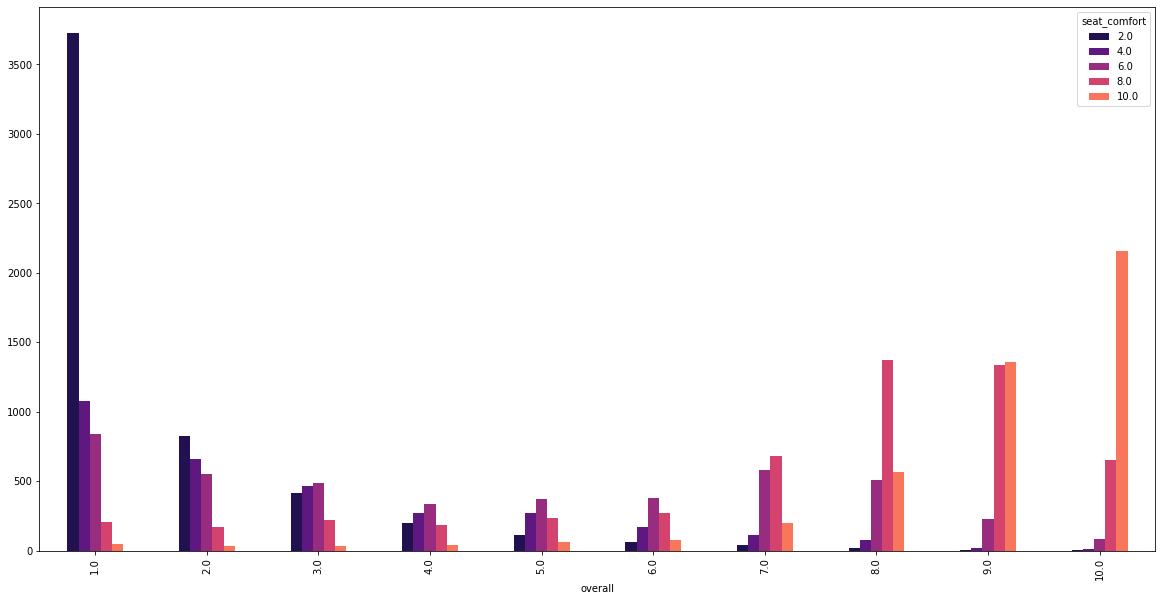

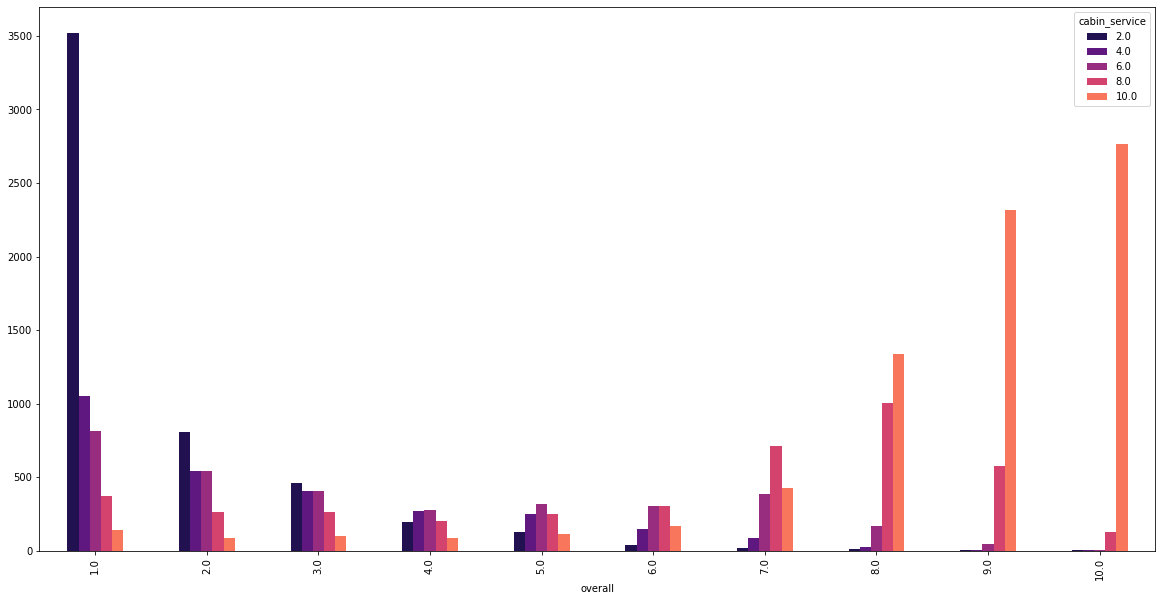

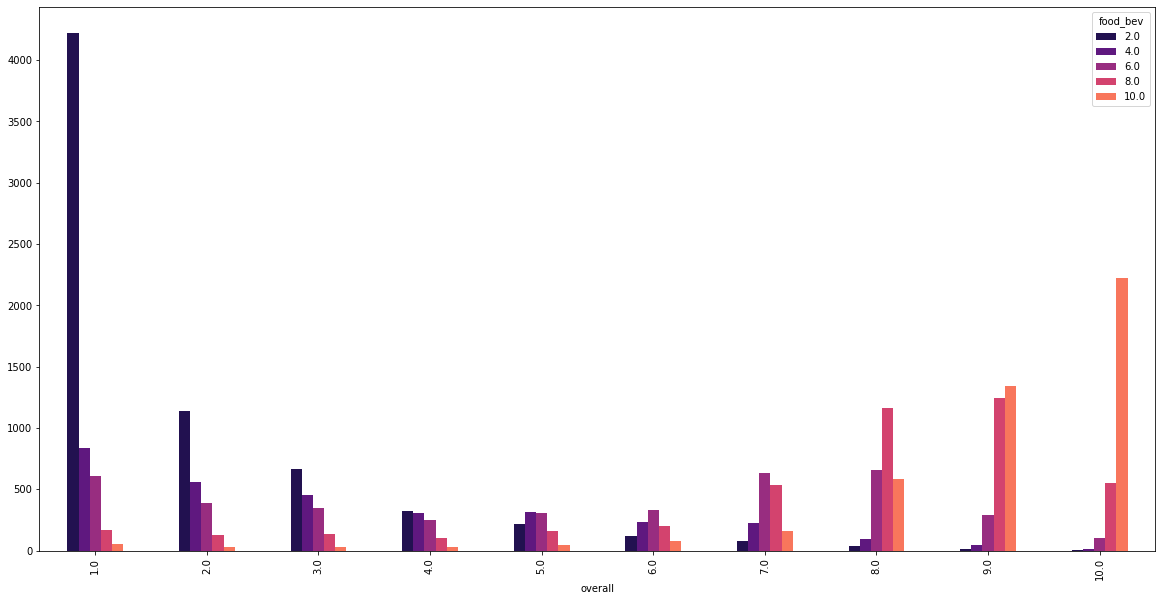

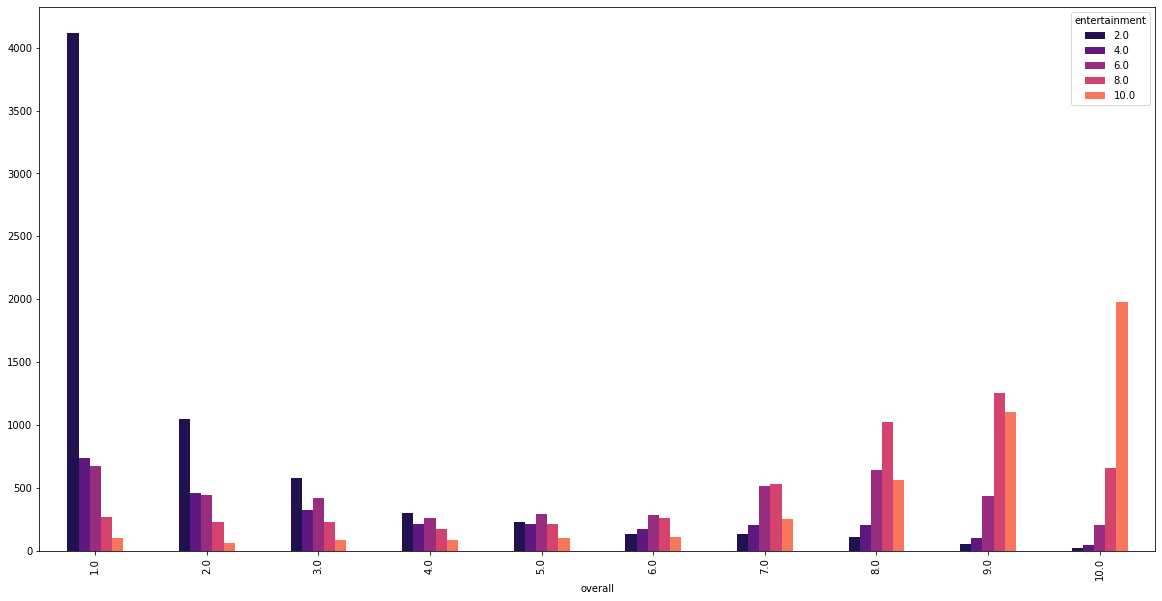

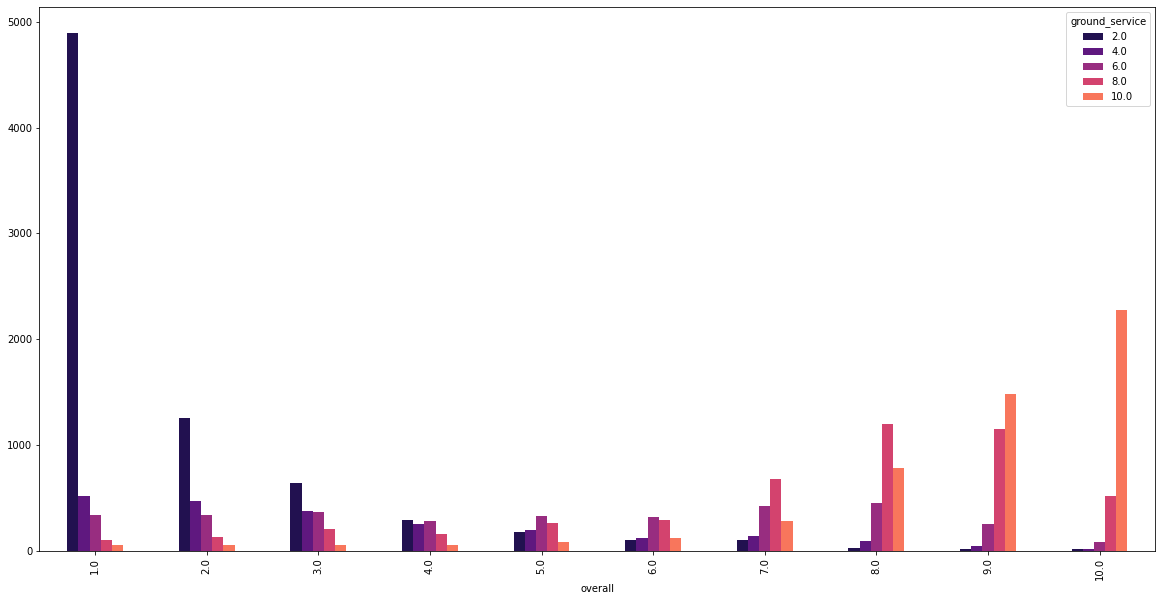

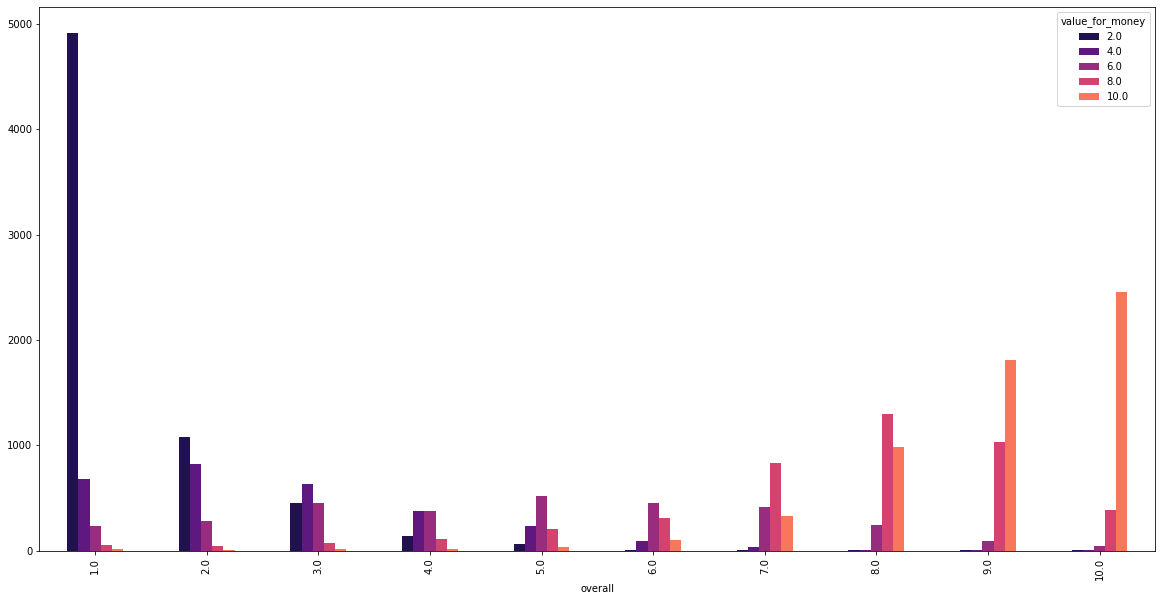

In [39]:
#Understanding the relationship of the various kinds of ratings with the overall ratings using a loop
sns.set_palette('magma')
for i in review_columns[1:]:
  x = airline_df.groupby([airline_df['overall']])
  x[i].value_counts().unstack().plot(kind= 'bar', figsize=(20,10))

As we can see above, the overall ratings column is a direct culmination of the all the other kind of review columns. The overall ratings increase with the increase in the other ratings.

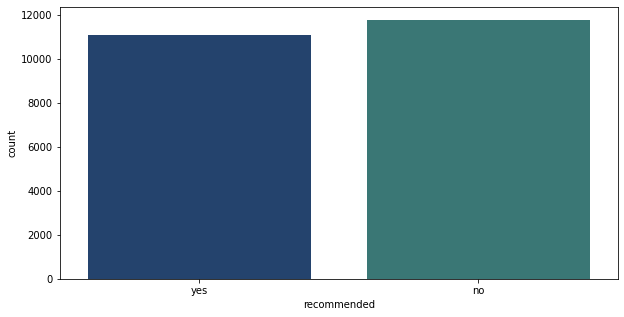

In [40]:
#Visualizing the recommendation count
sns.set_palette('gist_earth')
plt.figure(figsize=(10,5))
sns.countplot(x = 'recommended', data = airline_df)

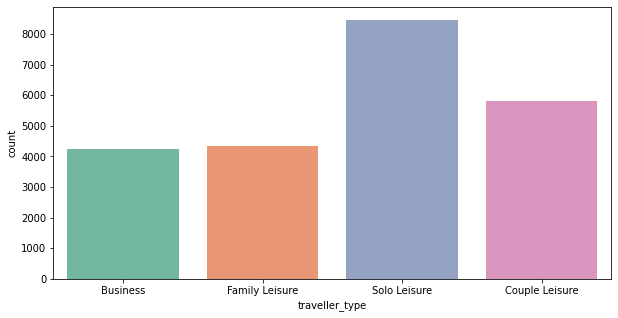

In [41]:
#Count of each type of travellers
sns.set_palette('Set2')
plt.figure(figsize=(10,5))
sns.countplot(x = 'traveller_type', data = airline_df)

Most number of reviews are from solo travellers.

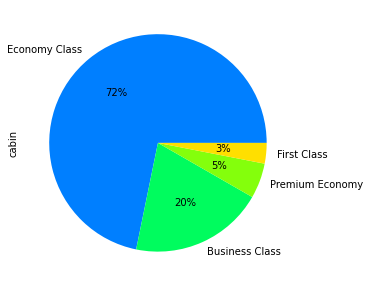

In [42]:
# Get the number of passengers for each cabin class through pie chart visualization
sns.set_palette('gist_ncar')
airline_df['cabin'].value_counts().plot(kind='pie',autopct='%1.0f%%',figsize=(10,5))



*   Most of the reviewers are economy class travellers.
*   First Class travellers are the minority reviewers here.



## **NLP Sentimental Analysis**

Let's start analyzing the reviews in text from the travellers and understand their sentiment and how has it impacted on their decision for the recommendation of the airlines.

In [43]:
#Checking the full text of customer review from the first column to have an understanding of how it looks
airline_df.iloc[0,:]['customer_review']

'âœ… Trip Verified | London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and pl

In [44]:
#Checking the route column and customer_review column side by side
airline_df[['route','customer_review']].head(20)

,route,customer_review
1,London to Izmir via Istanbul,âœ… Trip Verified | London to Izmir via Istanb...
3,Istanbul to Bucharest,âœ… Trip Verified | Istanbul to Bucharest. We ...
5,Rome to Prishtina via Istanbul,âœ… Trip Verified | Rome to Prishtina via Ista...
7,Washington Dulles to Karachi,âœ… Trip Verified | Flew on Turkish Airlines I...
9,Mumbai to Dublin via Istanbul,âœ… Trip Verified | Mumbai to Dublin via Istan...
11,Istanbul to Budapest via Dublin,âœ… Trip Verified | Istanbul to Budapest via D...
15,Basel to Cape Town via Istanbul,âœ… Trip Verified | Basel to Cape Town via Ist...
17,Abu Dhabi to Luxembourg via Istanbul,Not Verified | Abu Dhabi to Luxembourg via Ist...
19,Venice to Boston via Istanbul,âœ… Trip Verified | The experience with Turkis...
23,Tehran to New York via Istanbul,âœ… Trip Verified | Tehran to New York via Ist...


In [45]:
#Checking the route in the third column
airline_df.iloc[2,:]['route']

'Rome to Prishtina via Istanbul'

In [46]:
#Checking the full text of customer review from the third column to have an understanding of how it looks
airline_df.iloc[2,:]['customer_review']

'âœ… Trip Verified | Rome to Prishtina via Istanbul. I flew with this company several times in the past years, and I can honestly say that it is getting worse and worse. I flew from Rome to Prishtina via Istanbul, all 4 flights had a delay (which apparently is pretty normal with Turkish). The ground staff is for the most part useless. In Istambul i have tried to ask a few information about a flight delay (i had just 30 minutes before the connecting flight) and the whole answer was: "Relax Sir, No problem Sir, It\'s okay". The new airport is a gigantic mess, very big and disorganized. When you land in Istanbul it takes about 20 to 25 minutes taxiing and other 10 minutes before they actually start disembarking, it\'s an exhausting experience especially if you are in a hurry. Forget about asking for some indication at the new airport, they all chat between each other, some with a coffee in their hands. I flew with four different aircraft on this trip, two were fairly new, the other two we

In [47]:
#Checking the route in the 10th column from the last
airline_df.iloc[10,:]['route']

'Dublin to Tel Aviv via Ä°stanbul'

In [48]:
#Checking the full text of customer review in the 10th column from the last
airline_df.iloc[10,:]['customer_review']

'âœ… Trip Verified | Dublin to Tel Aviv via Ä°stanbul. First of all our flight was delayed for over an hour, but thatâ€™s fine we crossed that bridge, then when we arrived in Ä°stanbul airport we were told that we missed our connection flight. Ridiculous considering the fact the tickets were bought from Turkish Airlines and not from different companies, ok, 10 minutes of talking to customer service and we got new tickets from Ä°stanbul to Tel Aviv (not same comfortable plane as it supposed to be but still something) Arriving in Tel Aviv we found our 3 bags on the belt but so called oversized bag (which was actually a doll birthday box for my daughter) was missing almost 2 hours waiting for it to be found (no luck) then another half an hour of registering with lost&found made us exhausted (myself my husband and 2 kids aged 3 and 5 at 5am in the morning is no fun at all) We supposed to pick up our rental car in between 3-4am and when we came to get it apparently the car was gone to anoth

It's clear that the first part of the customer review before the full stop (.) contains the trip route and status. Since we already have another column with route details, this part is not required in the review. We can cut this part of the customer review after checking the trip status details too.

In [49]:
#Checking the number of trip verified mentions in the customer review column.
ver_count=airline_df['customer_review'].str.contains('Trip Verified').sum()
print ("There are {v} verified trips".format(v=ver_count))

There are 7662 verified trips


In [50]:
#Checking the number of not verified mentions in the customer review column.
not_ver_count=airline_df['customer_review'].str.contains('Not Verified').sum()
print ("{v} trips are not verified".format(v=not_ver_count))

887 trips are not verified


In [51]:
#total number of rows
len(airline_df)

22826

In [52]:
#calculating the number of rows with no information regarding trip verification status
no_info = len(airline_df)- (ver_count + not_ver_count )
print ("Verification details missing for {nf} trips".format(nf=no_info))

Verification details missing for 14277 trips


The number of customer reviews which doesn't mention the trip verification status is huge by a big margin compared to the ones which mention the verification status. So it is not worth moving this part to another column.

In [53]:
#Removing the part of customer review which mentions route and trip verification status
airline_df['customer_review'] = airline_df['customer_review'].str.split('.',n=1,expand=True)[1]

In [54]:
#Checking the change in same row which we checked earlier
airline_df.iloc[10,:]['customer_review']

' First of all our flight was delayed for over an hour, but thatâ€™s fine we crossed that bridge, then when we arrived in Ä°stanbul airport we were told that we missed our connection flight. Ridiculous considering the fact the tickets were bought from Turkish Airlines and not from different companies, ok, 10 minutes of talking to customer service and we got new tickets from Ä°stanbul to Tel Aviv (not same comfortable plane as it supposed to be but still something) Arriving in Tel Aviv we found our 3 bags on the belt but so called oversized bag (which was actually a doll birthday box for my daughter) was missing almost 2 hours waiting for it to be found (no luck) then another half an hour of registering with lost&found made us exhausted (myself my husband and 2 kids aged 3 and 5 at 5am in the morning is no fun at all) We supposed to pick up our rental car in between 3-4am and when we came to get it apparently the car was gone to another customer because we were late. We had no choice bu

These customer reviews in words give out lot of sentiments. This could be one of major deciding factors for recommendation .So let's work on these reviews.

Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts.

Lets apply this to our customer review column.

In [55]:
#Replacing all the null values of customer review column with 'NA'
airline_df['customer_review'].fillna('NA',inplace = True)

In [56]:
#importing all the libraries required for sentiment analysis
import string
import nltk 
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#downloading all the required packages
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [57]:
# Returning the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Including all the techniques for cleaning the text in a single function
def clean_text(text):

    # lower text
    text = text.lower()

    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]

    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # pos tag text
    pos_tags = pos_tag(text)

    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]

    # join all
    text = " ".join(text)
    
    return(text)

In [58]:
#Clean the customer_review column texts for sentiment analysis
airline_df["customer_review"] = airline_df["customer_review"].apply(lambda x: clean_text(x))

In [59]:
#checking one of the clean texts from one of the customer review columns
airline_df.iloc[10,:]['customer_review']

'first flight delay hour thatâ€™s fine cross bridge arrive ä°stanbul airport tell miss connection flight ridiculous consider fact ticket buy turkish airline different company ok minute talk customer service get new ticket ä°stanbul tel aviv comfortable plane suppose still something arrive tel aviv find bag belt call oversized bag actually doll birthday box daughter miss almost hour wait find luck another half hour register lost&found make exhausted husband kid age morning fun suppose pick rental car come get apparently car go another customer late choice get another expensive car available think turkish airline liable well register lose baggage give address phone number petah ask deliver go eilat day pretty much confident problem contact detail day later arrive back tel aviv contact lost&found ring see whatâ€™s story shock heard baggage deliver following day answer simple system baggage leave eilat next day deliver hotel really sorry get come left baggage hotel without notify answer de

In [60]:
#Make new columns for the negativity, positivity and neutrality derived from the sentiment analysis 
senti_analyzer = SentimentIntensityAnalyzer()
airline_df["review_Sentiments"] = airline_df["customer_review"].apply(lambda x: senti_analyzer.polarity_scores(x))
airline_df = pd.concat([airline_df.drop(['review_Sentiments'], axis=1), airline_df['review_Sentiments'].apply(pd.Series)], axis=1)


In [61]:
#Rename the new columns for better readability
airline_df.rename(columns={'neg':'Negative Sentiment Score', 'pos':'Positive Sentiment Score' ,
                           'neu' : 'Neutral Sentiment Score' , 'compound':'Overall Sentiment Score'}, inplace=True)

In [62]:
#Calculating the overall customer review sentiments
airline_df["Overall Review Sentiment"] = np.where(airline_df["Overall Sentiment Score"] >= 0.05,"Positive",
                                                       np.where(airline_df["Overall Sentiment Score"] <= -0.05,"Negative","Neutral"))


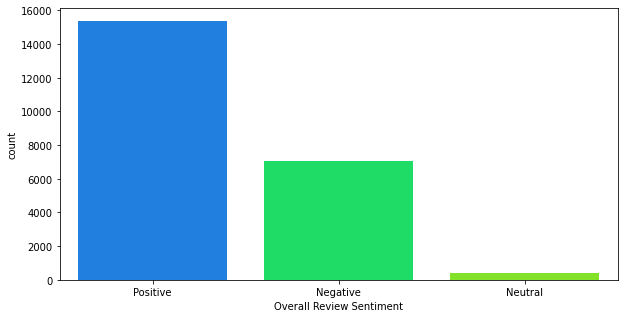

In [63]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Overall Review Sentiment', data = airline_df)

In [64]:
# re-ordering the index as rows are removed
airline_df.reset_index(drop=True,inplace = True)

In [65]:
#Lets split this dataset into three with respect to the overall review sentiment for some analysis
overall_positive= airline_df[airline_df["Overall Review Sentiment"] == "Positive"]
overall_negative= airline_df[airline_df["Overall Review Sentiment"] == "Negative"]
overall_neutral= airline_df[airline_df["Overall Review Sentiment"] == "Neutral"]

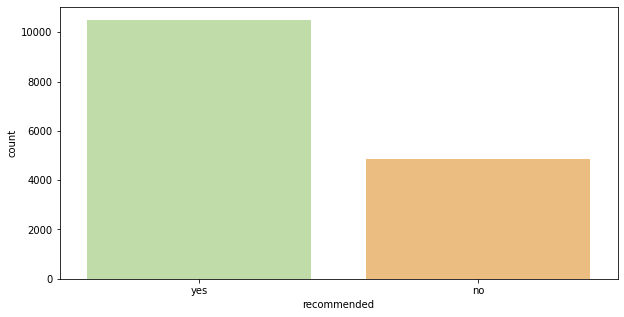

In [66]:
#Comparing the overall review sentiment positivity to the recommendation
plt.figure(figsize=(10,5))
sns.countplot(x = 'recommended', data = overall_positive , palette = "Spectral_r")

When the overall sentiment is positive, the reviewer is most likey to recommend the airlines to another person.

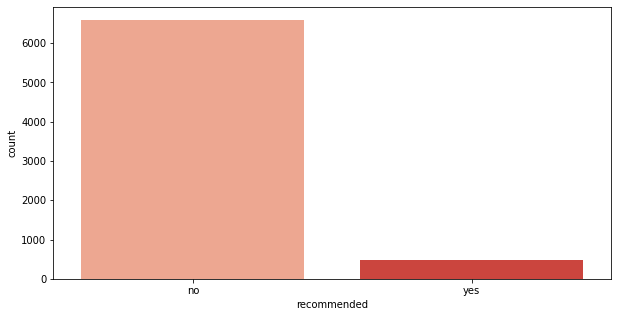

In [67]:
#Comparing the overall review sentiment negativity to the recommendation
plt.figure(figsize=(10,5))
sns.countplot(x = 'recommended', data = overall_negative , palette = "Reds")

When the review sentiment is negative, the reviewer is least likely to recommend.

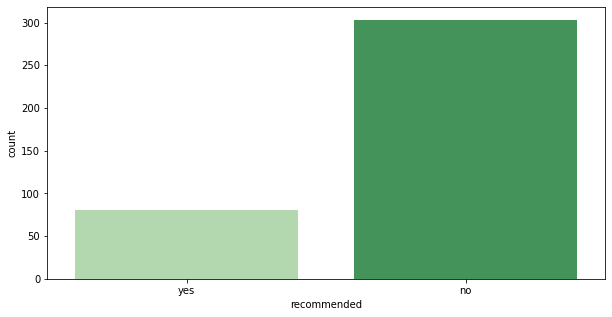

In [68]:
#Comparing the overall review sentiment neutrality to the recommendation
plt.figure(figsize=(10,5))
sns.countplot(x = 'recommended', data = overall_neutral , palette = "Greens")

If the overall sentiment is the review is neutral, theres is less chance of recommendation.

Since we have derived all the scores from the customer_review column, this is no longer useful. So, let's drop that too.

In [69]:
#Dropping the customer review column
airline_df.drop(["customer_review"], axis = 1, inplace = True)

In [70]:
#Checking the new shape of the dataset
airline_df.shape

(22826, 18)

In [71]:
#Last 5 rows of the dataset
airline_df.tail()

,airline,overall,review_date,traveller_type,cabin,route,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,Negative Sentiment Score,Neutral Sentiment Score,Positive Sentiment Score,Overall Sentiment Score,Overall Review Sentiment
22821,Ukraine International,1.0,6th August 2015,Family Leisure,Economy Class,New York to Lviv,2.0,2.0,2.0,2.0,2.0,2.0,no,0.123,0.753,0.124,-0.2023,Negative
22822,Ukraine International,1.0,2nd August 2015,Family Leisure,Economy Class,JFK to Tel Aviv via Kiev,2.0,4.0,2.0,2.0,2.0,2.0,no,0.191,0.765,0.044,-0.7845,Negative
22823,Ukraine International,10.0,20th July 2015,Couple Leisure,Economy Class,KBP to RIX,10.0,10.0,10.0,8.0,8.0,8.0,yes,0.000,0.660,0.340,0.8979,Positive
22824,Ukraine International,2.0,18th July 2015,Solo Leisure,Economy Class,Yerevan to Warsaw via Kiev,2.0,2.0,2.0,2.0,2.0,2.0,no,0.202,0.752,0.046,-0.8205,Negative
22825,Ukraine International,5.0,17th June 2015,Couple Leisure,Economy Class,Athens to JFK via Kiev,2.0,2.0,2.0,6.0,2.0,10.0,no,0.227,0.675,0.098,-0.9847,Negative


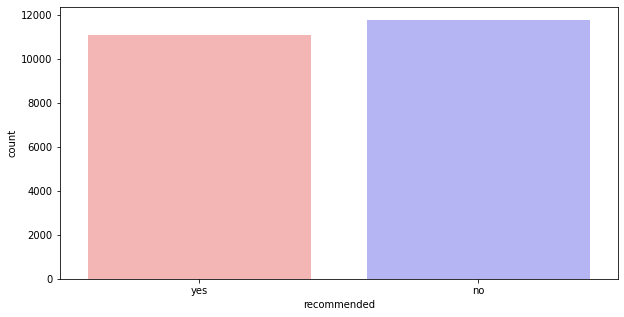

In [72]:
#Comparing the overall review sentiment positivity to the recommendation
plt.figure(figsize=(10,5))
sns.countplot(x = 'recommended', data = airline_df , palette = "bwr_r")

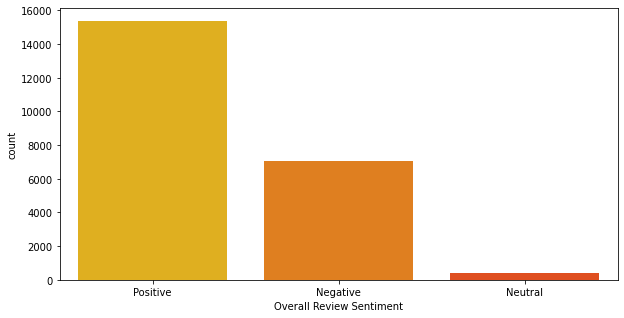

In [73]:
#Comparing the overall review sentiment count
plt.figure(figsize=(10,5))
sns.countplot(x = 'Overall Review Sentiment', data = airline_df , palette = "autumn_r")

We can drop the overall review sentiment column  there can be inaccuracies in the categorization as clear from the two graphs above.
Instead of the categorization, we can put more focus on the derived  senitment scores and its relationship with recommendation.

In [74]:
airline_df.columns

Index(['airline', 'overall', 'review_date', 'traveller_type', 'cabin', 'route',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended',
       'Negative Sentiment Score', 'Neutral Sentiment Score',
       'Positive Sentiment Score', 'Overall Sentiment Score',
       'Overall Review Sentiment'],
      dtype='object')

In [75]:
airline_df.route.nunique()

16072

In [76]:
airline_df.airline.nunique()

81

Text(0.5, 1.0, 'Airline Count Distribution')

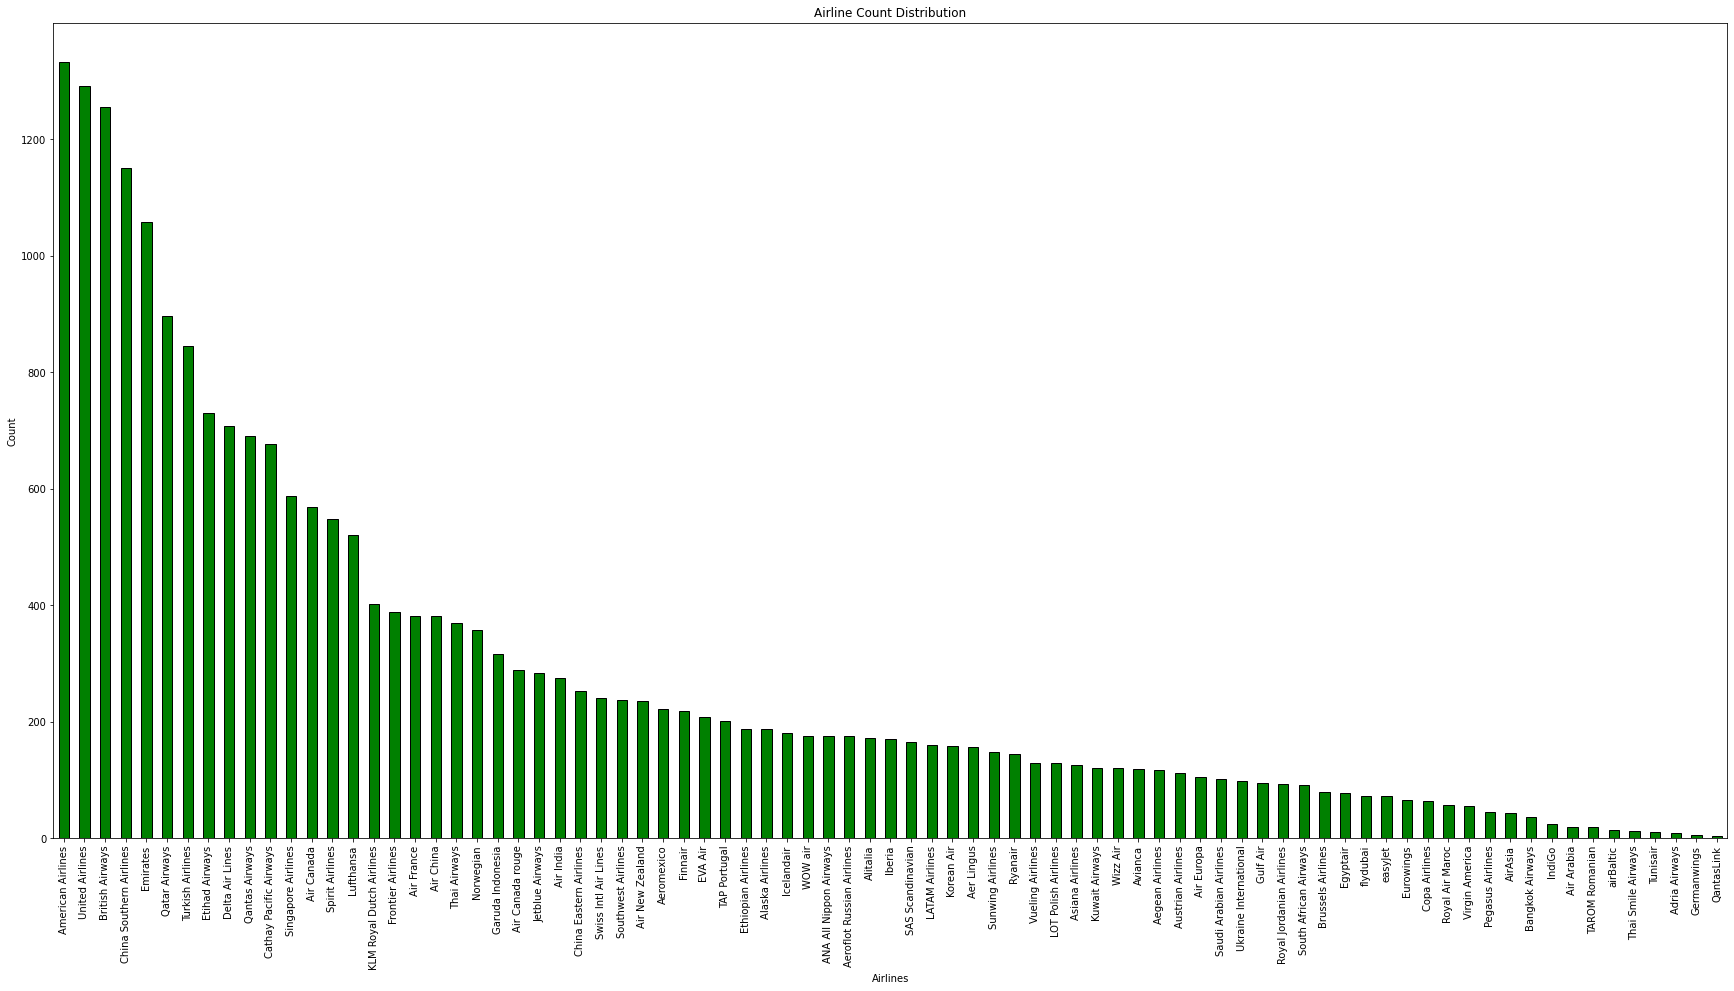

In [77]:
#Checking the reviews distribution with respect to the airlines
plt.figure(figsize=(30,15))
airline_df['airline'].value_counts().plot(kind="bar", align='center',color = 'green',edgecolor = 'black')
plt.xlabel("Airlines")
plt.ylabel("Count")
plt.title("Airline Count Distribution")

Text(0.5, 1.0, 'Airline Count Distribution')

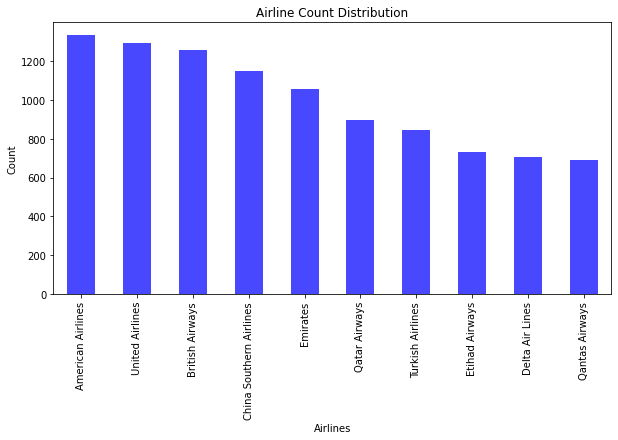

In [78]:
#Checking the reviews distribution with respect to the top 10 airlines with most number of reviews
plt.figure(figsize=(10,5))
sns.set_palette("bwr")
airline_df['airline'].value_counts().nlargest(10).plot(kind="bar")
plt.xlabel("Airlines")
plt.ylabel("Count")
plt.title("Airline Count Distribution")


Text(0.5, 1.0, 'Airline Count Distribution')

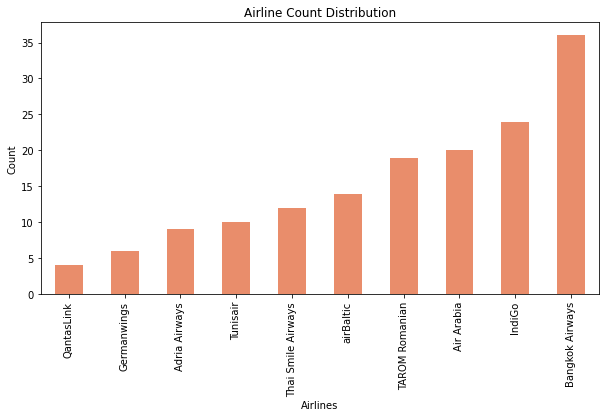

In [79]:
#Checking the reviews distribution with respect to the top airlines with least number of reviews
plt.figure(figsize=(10,5))
sns.set_palette("flare")
airline_df['airline'].value_counts().nsmallest(10).plot(kind="bar")
plt.xlabel("Airlines")
plt.ylabel("Count")
plt.title("Airline Count Distribution")




*   Maximum number of reviews are for American Airlines
*   Least number of reviews are for QantasLink



Text(0.5, 1.0, 'Traveller Type Count Distribution')

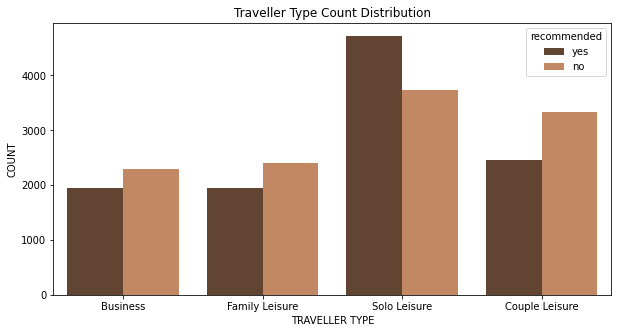

In [80]:
#Traveller Type Distribution
plt.figure(figsize=(10,5))
sns.countplot(x="traveller_type", hue="recommended", data=airline_df, palette="copper")
plt.xlabel("TRAVELLER TYPE")
plt.ylabel("COUNT")
plt.xticks(rotation=0)
plt.title("Traveller Type Count Distribution")

Text(0.5, 1.0, 'Cabin Type Count Distribution')

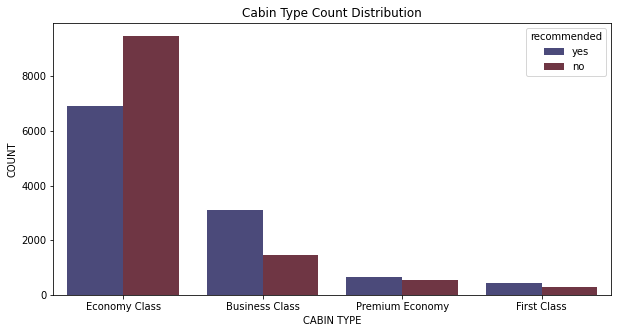

In [81]:
#Cabin Type Count Distribution
plt.figure(figsize=(10,5))
sns.countplot(x="cabin", hue="recommended", data=airline_df, palette="icefire")
plt.xlabel("CABIN TYPE")
plt.ylabel("COUNT")
plt.xticks(rotation=0)
plt.title("Cabin Type Count Distribution")

Text(0.5, 1.0, 'Cabin Type Count Distribution')

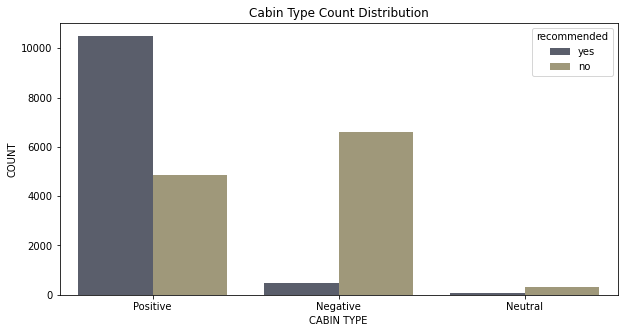

In [82]:
#Cabin Type Count Distribution
plt.figure(figsize=(10,5))
sns.countplot(x="Overall Review Sentiment", hue="recommended", data=airline_df, palette="cividis")
plt.xlabel("CABIN TYPE")
plt.ylabel("COUNT")
plt.xticks(rotation=0)
plt.title("Cabin Type Count Distribution")

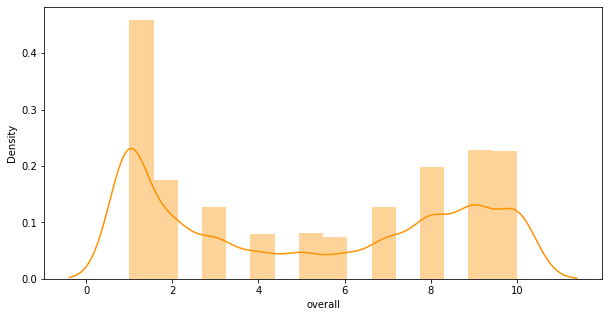

In [83]:
#Checking the density of the overall reviews
plt.figure(figsize=(10,5))
sns.set_palette("Wistia_r")
sns.distplot(airline_df['overall'])

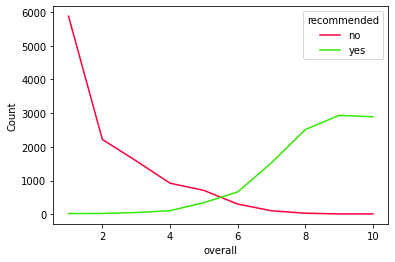

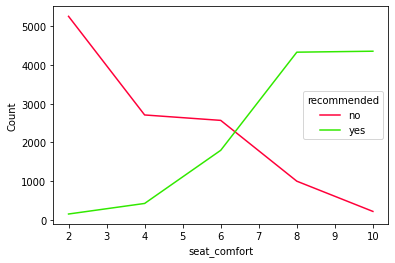

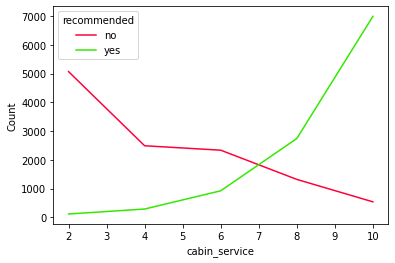

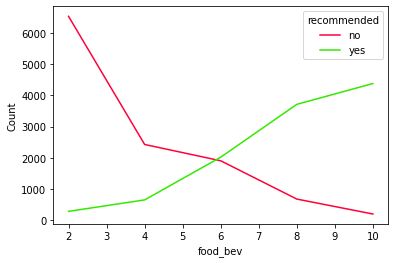

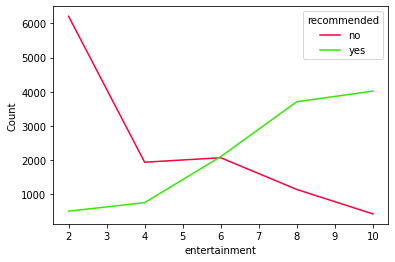

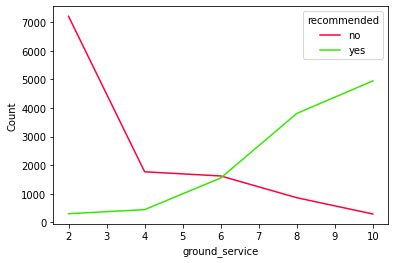

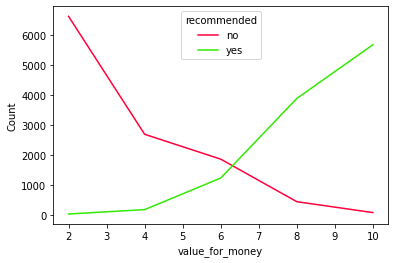

In [84]:
#Understanding the relationship of the various kinds of ratings with the overall ratings using a loop
for i in review_columns:
  count_rec = airline_df.groupby([i,'recommended'])[['recommended']].count()
  count_rec.columns = ['Count']
  count_rec = count_rec.reset_index()
  plt.figure()
  sns.lineplot(x=i, y='Count', hue='recommended', data=count_rec ,palette='prism_r')

The above plot shows the direct dependency of all type of ratings and the recommendation status. As the overall rating increases, there's more chance of recommendation. As the overall rating decreases decrease, there's less chance of recommendations.

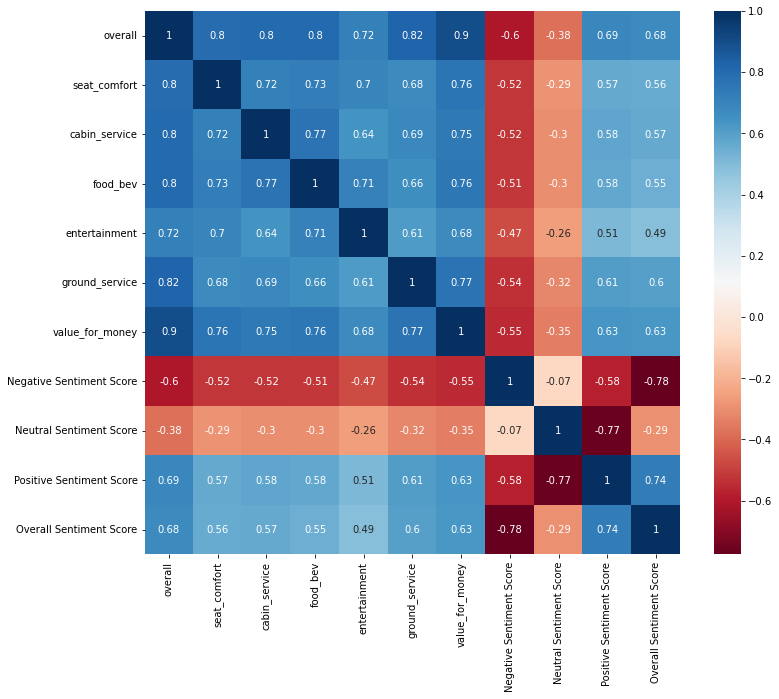

In [85]:
#Heatmap with correlation details
plt.figure(figsize=(12,10))
sns.heatmap(airline_df.corr(), annot=True, cmap='RdBu')

As we can see that the overall column is causing many cases of multicollinearity, we can drop this column. As deduced earlier, the overall rating column acts like a superset of all the other ratings, this removal shouldnt affect the accuracy of the model.

In [86]:
#Dropping the least significant null value columns
airline_df.drop(["overall"], axis = 1, inplace = True)

## **Data Preparation**

In [87]:
def label_encode(col):
  encode_dict = {'yes': 1, 'no':0}
  if col in encode_dict.keys():
    return encode_dict[col]

In [88]:
airline_df['recommended']=airline_df['recommended'].apply(lambda x: label_encode(x))

In [89]:
# label encoding the data 
l_encode = LabelEncoder() 
airline_df['cabin']= l_encode.fit_transform(airline_df['cabin']) 
airline_df['traveller_type']= l_encode.fit_transform(airline_df['traveller_type'])


In [90]:
airline_df.columns

Index(['airline', 'review_date', 'traveller_type', 'cabin', 'route',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended',
       'Negative Sentiment Score', 'Neutral Sentiment Score',
       'Positive Sentiment Score', 'Overall Sentiment Score',
       'Overall Review Sentiment'],
      dtype='object')

In [91]:
airline_df_before_dropping_imp = airline_df.copy()

In [92]:
airline_df.drop(['airline','review_date', 'route','Overall Review Sentiment'], axis = 1, inplace = True)

In [93]:
#Scaling back to 0 -5 rating
airline_df["seat_comfort"] = airline_df["seat_comfort"]/2
airline_df["cabin_service"] = airline_df["cabin_service"]/2
airline_df["food_bev"] = airline_df["food_bev"]/2
airline_df["entertainment"] = airline_df["entertainment"]/2
airline_df["ground_service"] = airline_df["ground_service"]/2
airline_df["value_for_money"] = airline_df["value_for_money"]/2

In [94]:
airline_df.describe()

,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,Negative Sentiment Score,Neutral Sentiment Score,Positive Sentiment Score,Overall Sentiment Score
count,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000,22826.000000
mean,1.745422,0.936169,3.023175,3.261982,2.861561,2.895251,2.908920,2.985192,0.484798,0.107501,0.675327,0.216951,0.343046
std,1.141042,0.659649,1.456319,1.568744,1.519159,1.507143,1.590355,1.581229,0.499780,0.089045,0.114418,0.139569,0.715312
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.993000
25%,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.039000,0.603000,0.109000,-0.381800
50%,2.000000,1.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,0.000000,0.094000,0.683000,0.193000,0.750600
75%,3.000000,1.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,1.000000,0.158750,0.754000,0.306750,0.947700
max,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,0.716000,1.000000,1.000000,0.998400


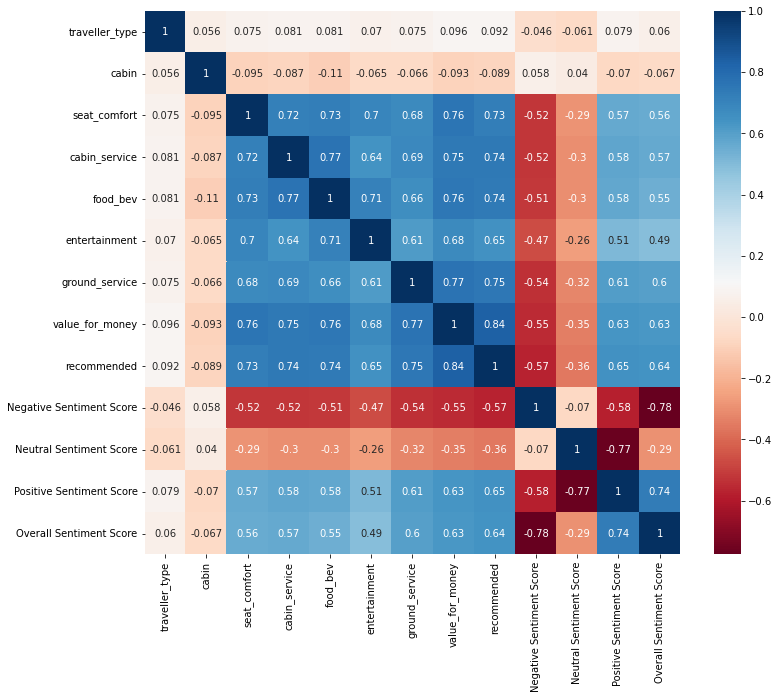

In [95]:
plt.figure(figsize=(12,10))
sns.heatmap(airline_df.corr(), annot=True, cmap='RdBu') #heatmap

## **Splitting  data into Training and Test Sets**

In [96]:
# Create the independent variable data
X = airline_df.drop(['recommended'],axis=1)


# Create the dependent variable data
y = airline_df['recommended']


In [97]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [98]:
#Checking the test and train sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17119, 12)
(17119,)
(5707, 12)
(5707,)


In [99]:
#Declaring a dataset for storing the evaluation metrics for each of the models
column_names = ["MODEL NAME", "ACCURACY", "RECALL","PRECISION","F1-SCORE","ROC AUC SCORE"]
metrics_df = pd.DataFrame(columns = column_names) 

In [100]:
def add_metrics_details(model_name,y_test,y_pred,df):
  df = df.append({'MODEL NAME': model_name, 
                  'ACCURACY':accuracy_score(y_test, y_pred), 
                  'RECALL': recall_score(y_test, y_pred),
                  'PRECISION':precision_score(y_test, y_pred),
                  'F1-SCORE':f1_score(y_test, y_pred),
                  'ROC AUC SCORE':roc_auc_score(y_test,y_pred)}
                  ,ignore_index=True)
  return df


## **Logistic Regression**

In [101]:
#Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9497108813737515

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.94      0.95      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 94.97108813737515%



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Model')

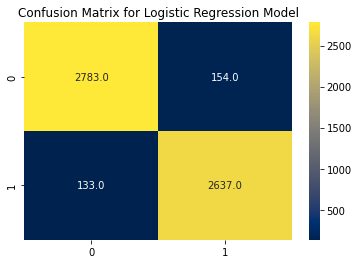

In [102]:
#Evaluation of the logistic regression model
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="cividis")
plt.title("Confusion Matrix for Logistic Regression Model")

In [103]:
metrics_df=add_metrics_details("Logistic Regression",y_test,y_pred,metrics_df)

## **XGBoost Model**

In [104]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb.score(X_test, y_test)

0.9493604345540564

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.95      0.95      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 94.93604345540564%



Text(0.5, 1.0, 'Confusion Matrix for XGBoost  Model')

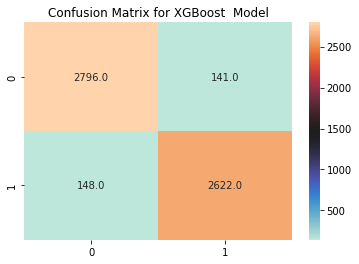

In [105]:
#Evaluation of the model
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="icefire")
plt.title("Confusion Matrix for XGBoost  Model")

In [106]:
metrics_df=add_metrics_details("XGBoost",y_test,y_pred,metrics_df)

## **Light GBM**

In [107]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

0.9467320834063431

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.94      0.95      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 94.6732083406343%



Text(0.5, 1.0, 'Confusion Matrix for Light GBM  Model')

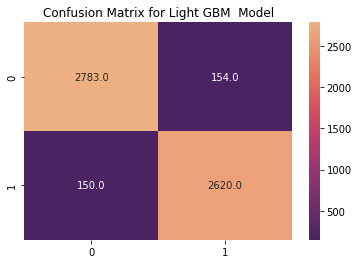

In [108]:
#Evaluation of the model
y_pred = lgbm.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="flare_r")
plt.title("Confusion Matrix for Light GBM  Model")

In [109]:
metrics_df=add_metrics_details("Light GBM",y_test,y_pred,metrics_df)

## **Random Forest**

In [110]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_test, y_test)

0.9481338706851236

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.95      0.94      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 94.81338706851236%



Text(0.5, 1.0, 'Confusion Matrix for Random Forest  Model')

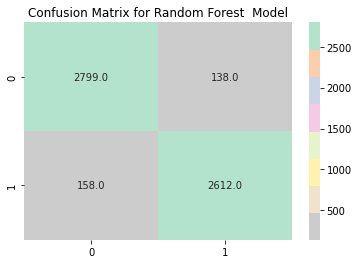

In [111]:
#Evaluation of the model
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="Pastel2_r")
plt.title("Confusion Matrix for Random Forest  Model")

In [112]:
metrics_df=add_metrics_details("Random Forest",y_test,y_pred,metrics_df)

## **Support Vector Machine**

In [113]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9507622218328369

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.95      0.95      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 95.07622218328369%



Text(0.5, 1.0, 'Confusion Matrix for Support Vector Model')

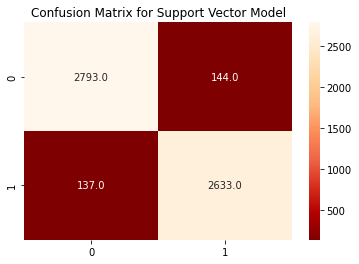

In [114]:
#Evaluation of the model
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="OrRd_r")
plt.title("Confusion Matrix for Support Vector Model")

In [115]:
metrics_df=add_metrics_details("Support Vector Machine",y_test,y_pred,metrics_df)

## **Decision Tree**

In [116]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.9158927632731733

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2937
           1       0.91      0.92      0.91      2770

    accuracy                           0.92      5707
   macro avg       0.92      0.92      0.92      5707
weighted avg       0.92      0.92      0.92      5707

Accuracy of the Model: 91.58927632731732%



Text(0.5, 1.0, 'Confusion Matrix for Decision Tree  Model')

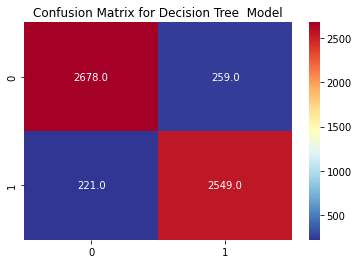

In [117]:
#Evaluation of the model
y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdYlBu_r")
plt.title("Confusion Matrix for Decision Tree  Model")

In [118]:
metrics_df=add_metrics_details("Decision Tree",y_test,y_pred,metrics_df)

## **K-Nearest Neighbour Model**

In [119]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)

0.9413001577010689

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2937
           1       0.93      0.95      0.94      2770

    accuracy                           0.94      5707
   macro avg       0.94      0.94      0.94      5707
weighted avg       0.94      0.94      0.94      5707

Accuracy of the Model: 94.1300157701069%



Text(0.5, 1.0, 'Confusion Matrix for KNN  Model')

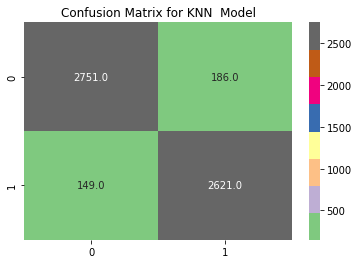

In [120]:
#Evaluation of the model
y_pred = knc.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="Accent")
plt.title("Confusion Matrix for KNN  Model")

In [121]:
metrics_df=add_metrics_details("KNN Model",y_test,y_pred,metrics_df)

## **XGBoost -GridSearchCV**

In [122]:
# Hyperparameter Tuning
param_dict = {'n_estimators' : [50,80,100],
              'max_depth' : [6,8,10,12],
              'min_samples_split' : [10,50,100],
              'min_samples_leaf' : [30,40,50]}

In [123]:
xg_model_gridcv = GridSearchCV(estimator=xgb,
                       param_grid = param_dict,
                       cv = 5, verbose=2)

In [124]:
xg_model_gridcv.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.9s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.9s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.9s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.9s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] max_depth=6, min_samples_leaf=30, min_samples_s

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 17.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [30, 40, 50],
                         'min_samples_split': [10, 50, 100],
   

In [125]:
xg_model_gridcv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, min_samples_leaf=30, min_samples_split=10,
              missing=None, n_estimators=50, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [126]:
xg_model_gridcv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 30,
 'min_samples_split': 10,
 'n_estimators': 50}

In [127]:
xg_model_gridcv_best = xg_model_gridcv.best_estimator_

In [128]:
y_pred = xg_model_gridcv_best.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2937
           1       0.94      0.94      0.94      2770

    accuracy                           0.94      5707
   macro avg       0.94      0.94      0.94      5707
weighted avg       0.94      0.94      0.94      5707

Accuracy of the Model: 94.44541790783248%



Text(0.5, 1.0, 'Confusion Matrix for XGBoost - GridSearchCV')

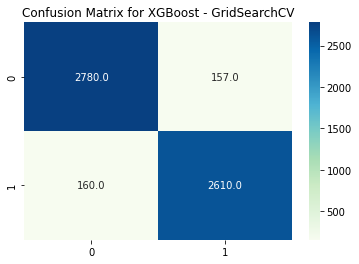

In [129]:
#Evaluation of the model
y_pred = xg_model_gridcv_best.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="GnBu")
plt.title("Confusion Matrix for XGBoost - GridSearchCV")

In [130]:
metrics_df=add_metrics_details("XGBoost - GridSearchCV",y_test,y_pred,metrics_df)

## **Random Forest - GridSearchCV**

In [131]:
rf_gridcv = GridSearchCV(estimator=rf,
                       param_grid = param_dict,
                       cv = 5, verbose=2)

#Evaluating the optimal parameters
rf_gridcv.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.5s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.5s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.5s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.5s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=50, total=   0.5s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80, total=   0.8s
[CV] max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80 
[CV]  max_depth=6, min_samples_leaf=30, min_samples_split=10, n_estimators=80, total=   0.8s
[CV] max_depth=6, min_samples_leaf=30, min_samples_s

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  7.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [132]:
rf_gridcv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
rf_gridcv.best_params_


{'max_depth': 8,
 'min_samples_leaf': 30,
 'min_samples_split': 10,
 'n_estimators': 50}

In [134]:
rf_gridcv_best = rf_gridcv.best_estimator_

In [135]:
y_pred =rf_gridcv_best.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2937
           1       0.95      0.94      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 95.02365516032943%



Text(0.5, 1.0, 'Confusion Matrix for Random Forest - GridSearchCV')

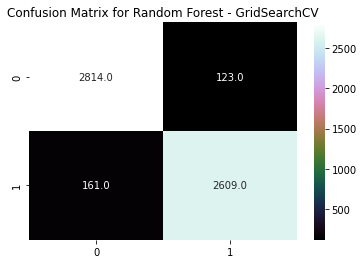

In [136]:
#Evaluation of the model
y_pred = rf_gridcv_best.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="cubehelix")
plt.title("Confusion Matrix for Random Forest - GridSearchCV")

In [137]:
metrics_df=add_metrics_details("Random Forest - GridSearchCV",y_test,y_pred,metrics_df)

## **KNN -GridSearchCV**

In [138]:
knn_params = {'n_neighbors':np.arange(10,50,2)}
knn_cv = GridSearchCV(knc, knn_params, cv=5)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [139]:
knn_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=48, p=2,
                     weights='uniform')

In [140]:
knn_cv_best = knn_cv.best_estimator_

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2937
           1       0.94      0.95      0.95      2770

    accuracy                           0.95      5707
   macro avg       0.95      0.95      0.95      5707
weighted avg       0.95      0.95      0.95      5707

Accuracy of the Model: 94.83090940949711%



Text(0.5, 1.0, 'Confusion Matrix for KNN - GridSearchCV')

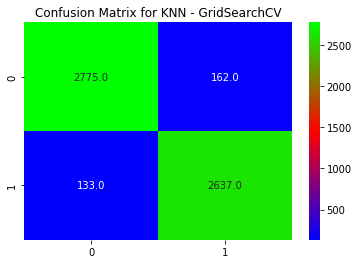

In [141]:
#Evaluation of the model
y_pred = knn_cv_best.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix( y_test,y_pred)

print("Accuracy of the Model: {}%\n".format((accuracy_score( y_test,y_pred))*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="brg")
plt.title("Confusion Matrix for KNN - GridSearchCV")

In [142]:
metrics_df=add_metrics_details("KNN - GridSearchCV",y_test,y_pred,metrics_df)

## **PREDICTION MODEL COMPARISON**

In [143]:
#Display the evaluation metrics dataset
metrics_df

,MODEL NAME,ACCURACY,RECALL,PRECISION,F1-SCORE,ROC AUC SCORE
0,Logistic Regression,0.949711,0.951986,0.944823,0.948391,0.949776
1,XGBoost,0.949360,0.946570,0.948969,0.947768,0.949281
2,Light GBM,0.946732,0.945848,0.944484,0.945166,0.946707
3,Random Forest,0.948134,0.942960,0.949818,0.946377,0.947987
4,Support Vector Machine,0.950762,0.950542,0.948145,0.949342,0.950756
5,Decision Tree,0.915893,0.920217,0.907764,0.913948,0.916016
6,KNN Model,0.941300,0.946209,0.933737,0.939932,0.941440
7,XGBoost - GridSearchCV,0.944454,0.942238,0.943260,0.942749,0.944391
8,Random Forest - GridSearchCV,0.950237,0.941877,0.954978,0.948382,0.949999
9,KNN - GridSearchCV,0.948309,0.951986,0.942122,0.947028,0.948414


In [144]:
#Sorting the dataset by accuracy score
metrics_df.sort_values("ACCURACY",ascending=False)


,MODEL NAME,ACCURACY,RECALL,PRECISION,F1-SCORE,ROC AUC SCORE
4,Support Vector Machine,0.950762,0.950542,0.948145,0.949342,0.950756
8,Random Forest - GridSearchCV,0.950237,0.941877,0.954978,0.948382,0.949999
0,Logistic Regression,0.949711,0.951986,0.944823,0.948391,0.949776
1,XGBoost,0.949360,0.946570,0.948969,0.947768,0.949281
9,KNN - GridSearchCV,0.948309,0.951986,0.942122,0.947028,0.948414
3,Random Forest,0.948134,0.942960,0.949818,0.946377,0.947987
2,Light GBM,0.946732,0.945848,0.944484,0.945166,0.946707
7,XGBoost - GridSearchCV,0.944454,0.942238,0.943260,0.942749,0.944391
6,KNN Model,0.941300,0.946209,0.933737,0.939932,0.941440
5,Decision Tree,0.915893,0.920217,0.907764,0.913948,0.916016


In [145]:
#Modifying the dataset into descending order of accuracy
metrics_df=metrics_df.sort_values("ACCURACY",ascending=False)
metrics_df = metrics_df.reset_index(drop=True)
metrics_df

,MODEL NAME,ACCURACY,RECALL,PRECISION,F1-SCORE,ROC AUC SCORE
0,Support Vector Machine,0.950762,0.950542,0.948145,0.949342,0.950756
1,Random Forest - GridSearchCV,0.950237,0.941877,0.954978,0.948382,0.949999
2,Logistic Regression,0.949711,0.951986,0.944823,0.948391,0.949776
3,XGBoost,0.949360,0.946570,0.948969,0.947768,0.949281
4,KNN - GridSearchCV,0.948309,0.951986,0.942122,0.947028,0.948414
5,Random Forest,0.948134,0.942960,0.949818,0.946377,0.947987
6,Light GBM,0.946732,0.945848,0.944484,0.945166,0.946707
7,XGBoost - GridSearchCV,0.944454,0.942238,0.943260,0.942749,0.944391
8,KNN Model,0.941300,0.946209,0.933737,0.939932,0.941440
9,Decision Tree,0.915893,0.920217,0.907764,0.913948,0.916016


Lets's format our evaluation score to percentage for readability

In [146]:
#Function for rounding the percentages of evaluation metrics score
def round_perc(val):
  val = round(val*100,2)
  return val

In [147]:
#checking the column names
metrics_df.columns

Index(['MODEL NAME', 'ACCURACY', 'RECALL', 'PRECISION', 'F1-SCORE',
       'ROC AUC SCORE'],
      dtype='object')

In [148]:
#Putting the metrics_df column names in a list
metrics_columns = metrics_df.columns

In [149]:
#loop for formatting the evaluation scores
for i in metrics_columns[1:]:
  metrics_df[i] = round_perc(metrics_df[i])

In [150]:
#Modified dataset of evaluation metrics dataset
metrics_df

,MODEL NAME,ACCURACY,RECALL,PRECISION,F1-SCORE,ROC AUC SCORE
0,Support Vector Machine,95.08,95.05,94.81,94.93,95.08
1,Random Forest - GridSearchCV,95.02,94.19,95.50,94.84,95.00
2,Logistic Regression,94.97,95.20,94.48,94.84,94.98
3,XGBoost,94.94,94.66,94.90,94.78,94.93
4,KNN - GridSearchCV,94.83,95.20,94.21,94.70,94.84
5,Random Forest,94.81,94.30,94.98,94.64,94.80
6,Light GBM,94.67,94.58,94.45,94.52,94.67
7,XGBoost - GridSearchCV,94.45,94.22,94.33,94.27,94.44
8,KNN Model,94.13,94.62,93.37,93.99,94.14
9,Decision Tree,91.59,92.02,90.78,91.39,91.60


## **CONCLUSION**


From the above table for model evaluation metrics comparison, we can see that **Support Vector Machine** being the model with highest accuracy rate by a very small margin, works best among the experimented regression models for the given dataset.






In [151]:
#  Classification analysis and prediction done by Nayana Pradeep